In [6]:
using Distributions, PyPlot, PyCall
cv2 = pyimport("cv2")

PyObject <module 'cv2.cv2' from '/opt/conda/lib/python3.7/site-packages/cv2/cv2.cpython-37m-x86_64-linux-gnu.so'>

# Section5-1
この章では、領域に、基く濃淡変換を説明する。
- 空間フィルタリング
    - 入力画像の対応する画素値だけでなく、その周囲の画素も含めた領域内の画素値を用いて計算する

## 空間フィルタ（本書では線形フィルタのみ）
$$ g(i,j) = \sum^W_{n = -W} \sum^W_{m = -W} f(i + m, j + n)h(m,n)$$
ただし、
$f(i,j)$を入力フィルタ, $h(m,n)$をフィルタの係数を表す配列とし、フィルタの大きさを$(2W + 1)^2$とする。

![fig5.2](./img/fig5.2.png)

上の図の場合、
$$
\begin{align}
    f(-1,-1) &= f(-1,0) = f(-1,1) = f(0,-1) = 50 \\
    f(0,0) &= f(0,1) = 100  \\
    f(1,-1) &= f(1,0) = f(1,1) = 120
\end{align}
$$

$$
h(m,n) = \begin{cases}
    9 & (m = n = 0) \\
    -1 & (otherwise)
\end{cases}
$$

In [199]:
input = [50  50  50
         50 100 100
        120 120 120]

input_filter = [-1 -1 -1
                -1  9 -1
                -1 -1 -1]
W = 1



f(i,j) = input[i+2,j+2]
h(i,j) = input_filter[i+2, j+2]
g(i,j) = sum(map(n -> sum(map(m -> f(i + m, j + n) * h(m, n), -W:W)), -W:W))

g (generic function with 1 method)

In [208]:
vec(input)' * vec(input_filter)

240

In [200]:
g(0,0)

240

In [267]:
zero_miman_filter(value) = value < 0 ? 0 : value
uint_filter(value) = value > 255 ? uint_filter(value - 256) : value
function filtering(input_img, input_filter, filter_size)
    X, Y = size(input_img)
    filtering_img = copy(input_img)
    for x ∈ 1:X-filter_size+1
        for y ∈ 1:Y-filter_size+1
            filtering_img[(x+1) + y * X] = UInt8(
                uint_filter(floor(
                    zero_miman_filter(vec(input_img[x:x+(filter_size-1), y:y+(filter_size-1)])' * vec(input_filter))
                ))
            )
        end
    end
    filtering_img
end

filtering(input, input_filter, 3)

3×3 Array{Int64,2}:
  50   50   50
  50  240  100
 120  120  120

カラー画像の場合、RGB上の書くチャンネルに対して、上同様の処理を行なっていく。

# Section5-2

## 平滑化
ぼけた画像は濃淡の変化が滑らかである。
- 画像に含まれるノイズなどの不要な濃淡変動を軽減するために用いられる

### 5-2-1 平均化
フィルタに覆われる領域内の画素値の平均を求めて適用
フィルタは3x3で
$$
  filter = \frac{1}{9} \left(
    \begin{array}{ccc}
      1 & 1 & 1 \\
      1 & 1 & 1 \\
      1 & 1 & 1
    \end{array}
  \right)
$$

### 5-2-2 重み付き平均化
中心に近いほど大きな重みをつける手法
さらに、それをガウス分布に近づけたものをガウシアンフィルタと呼ぶ
フィルタは3x3で
$$
  filter = \frac{1}{16} \left(
    \begin{array}{ccc}
      1 & 2 & 1 \\
      2 & 4 & 2 \\
      1 & 2 & 1
    \end{array}
  \right)
$$


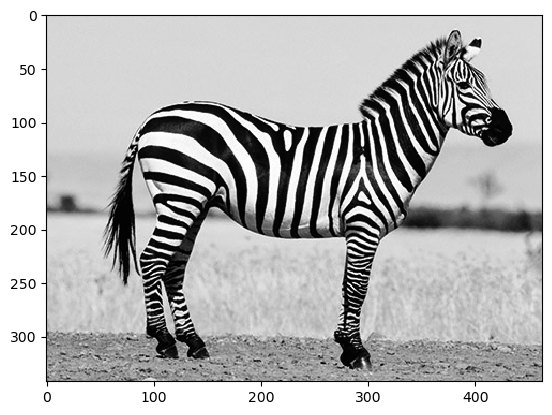

PyObject <matplotlib.image.AxesImage object at 0x7fdf34219080>

In [268]:
gray()
# sample
img = cv2.imread("img/fig5.jpg", 0)
imshow(img)

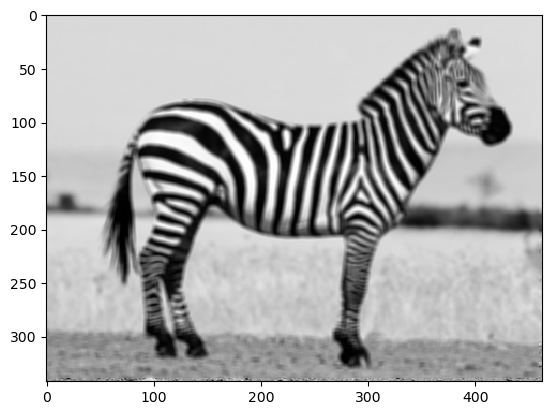

PyObject <matplotlib.image.AxesImage object at 0x7fdf341f5128>

In [269]:
# 平均化
filter_size = 5
average_filter(size) = begin
    if size == 3
        [1/9 1/9 1/9 
         1/9 1/9 1/9 
         1/9 1/9 1/9]
    elseif size == 5
        [1/25 1/25 1/25 1/25 1/25
         1/25 1/25 1/25 1/25 1/25
         1/25 1/25 1/25 1/25 1/25
         1/25 1/25 1/25 1/25 1/25
         1/25 1/25 1/25 1/25 1/25]
    end
end
imshow(filtering(img, average_filter(filter_size), filter_size))

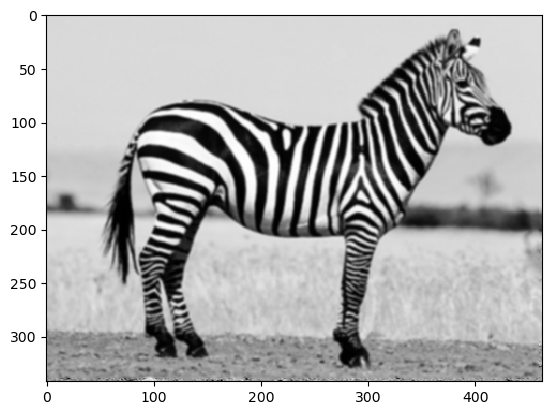

PyObject <matplotlib.image.AxesImage object at 0x7fdf341d21d0>

In [270]:
## 重み付き平均化
filter_size = 5
gaussian_filter(size) = begin
    if size == 3
        [1/16 2/16 1/16 
         2/16 4/16 2/16 
         1/16 2/16 1/16]
    elseif size == 5
        [1/256 4/256 6/256 4/256 1/256
        4/256 16/256 24/256 16/256 4/256
        6/256 24/256 36/256 24/256 6/256
        4/256 16/256 24/256 16/256 4/256
        1/256 4/256 6/256 4/256 1/256]
    end
end
imshow(filtering(img, gaussian_filter(filter_size), filter_size))

# 5-3 エッジ抽出
画像の明暗がはっきりしている部分のフィルタ

隣あう画素の差分を求めたものをフィルタとする。
$$
  I_x(x,y) = f(x + 1, y) - f(x, y) \\
  I_y(x,y) = f(x, y + 1) - f(x, y)
$$

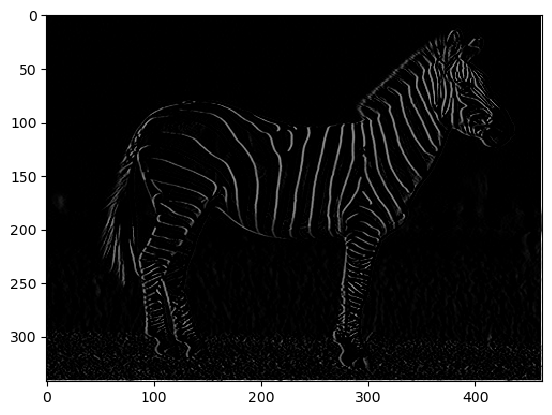

PyObject <matplotlib.image.AxesImage object at 0x7fdf43c1d8d0>

In [366]:
## 重み付き平均化
filter_size = 3
diff_tate_filter_a = [0 0 0
                 0 1 -1
                 0 0 0]
diff_tate_filter_b = [0 0 0
                1 -1 0
                 0 0 0]
diff_tate_filter_c = [0 0 0
                 1/2 0 -1/2
                 0 0 0]

imshow(filtering(img, diff_tate_filter_c, filter_size))

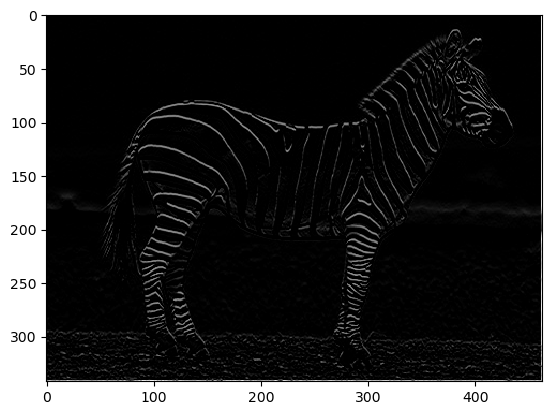

PyObject <matplotlib.image.AxesImage object at 0x7fdf3410e320>

In [272]:
## 重み付き平均化
filter_size = 3
diff_yoko_filter_a = [0 1 0
                      0 -1 0
                      0 0 0]
diff_yoko_filter_b = [0 0 0
                      0 1 0
                      0 -1 0]
diff_yoko_filter_c = [0 1/2 0
                      0 0  0
                      0 -1/2 0]

imshow(filtering(img, diff_yoko_filter_c, filter_size))

## 5-3-2 プリューウィットフィルタ
横方向微分フィルタ -> 縦方向平滑化フィルタを実行

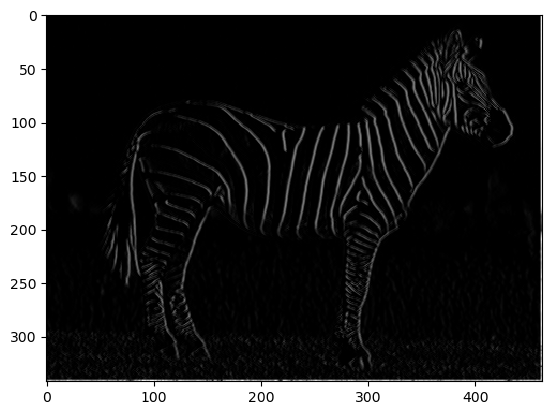

PyObject <matplotlib.image.AxesImage object at 0x7fdf3406d3c8>

In [273]:
b_1 = filtering(img, [0 0 0;-1/2 0 1/2;0 0 0], filter_size)
b_2 = filtering(b_1, [0 1/3 0;0 0 1/3;0 1/3 0], filter_size)
imshow(6 * b_2)

In [274]:
b_filter = [-1 0 1;-1 0 1;-1 0 1]

3×3 Array{Int64,2}:
 -1  0  1
 -1  0  1
 -1  0  1

この行列と等価となる

filter: `[0 0 0;-1/2 0 1/2;0 0 0]`をとおす。
$$A_{i,j} = 1/2 * (A_{i-1, j} - A_{i+1, j})$$

filter: `[0 1/3 0;0 0 1/3;0 1/3 0]`をとおす
$$A_{i,j} = 1/3 * (A_{i, j-1} + A_{i, j} + A_{i, j+1})$$

それぞれ
$$A_{i, j-1} = 1/2 * (A_{i-1, j-1} - A_{i+1, j-1})$$
$$A_{i,j} = 1/2 * (A_{i-1, j} - A_{i+1, j})$$
$$A_{i, j+1} = 1/2 * (A_{i-1, j+1} - A_{i+1, j+1})$$

よって
$$A_{i,j} = 1/6(A_{i-1, j-1} - A_{i+1, j-1} + A_{i-1, j} - A_{i+1, j} + A_{i-1, j+1} - A_{i+1, j+1})$$

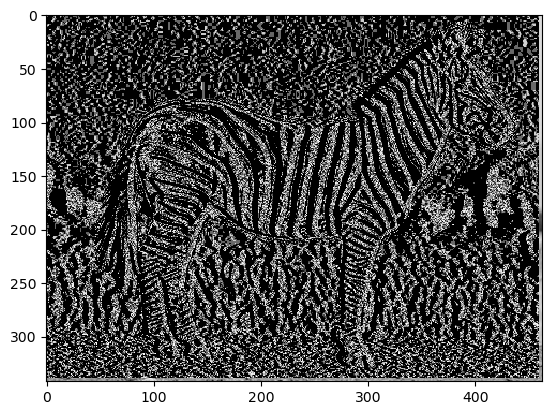

PyObject <matplotlib.image.AxesImage object at 0x7fdf32b02be0>

In [372]:
imshow(filtering(img, [-1 0 0 0 1;-2 0 0 0 2;-100 0 0 0 100;-2 0 0 0 2;-1 0 0 0 1], 5))

## 5-3-3 ２次元微分フィルタ

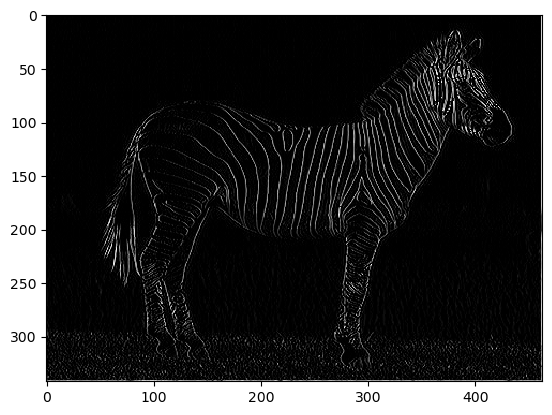

PyObject <matplotlib.image.AxesImage object at 0x7fdf3404a470>

In [275]:
imshow(filtering(img, [0 0 0;1 -2 1;0 0 0], 3))

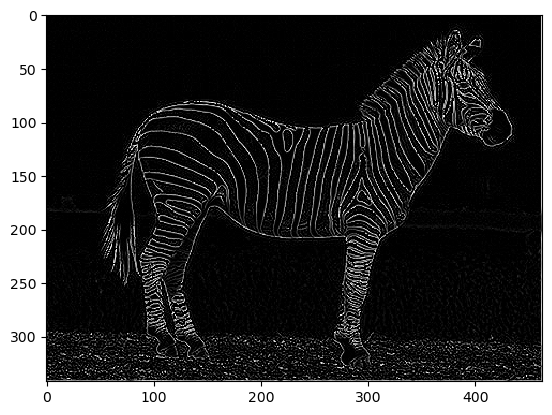

PyObject <matplotlib.image.AxesImage object at 0x7fdf33fa9518>

In [276]:
## ラプラシアンフィルタ
imshow(filtering(img, [0 1 0;1 -4 1;0 1 0], 3))

## 鮮鋭化
画像の濃淡を残したまま、エッジを強調する処理

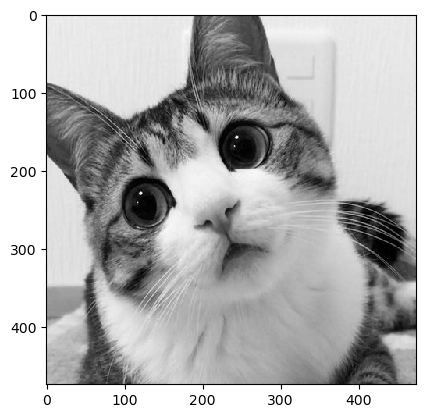

PyObject <matplotlib.image.AxesImage object at 0x7fdf32a41438>

In [374]:
cat = cv2.imread("img/fig5-2-1.jpg", 0);
imshow(cat)

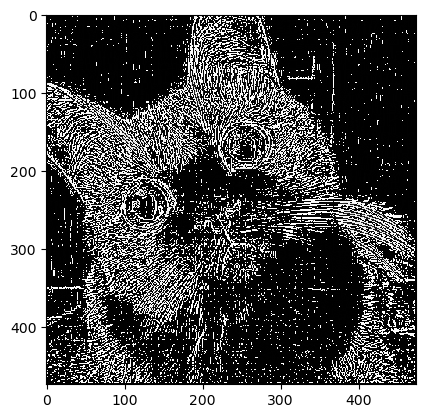

PyObject <matplotlib.image.AxesImage object at 0x7fdf327d4be0>

In [380]:
ave_cat = filtering(cat, gaussian_filter(3), 3)
b = cat - ave_cat
imshow(b)

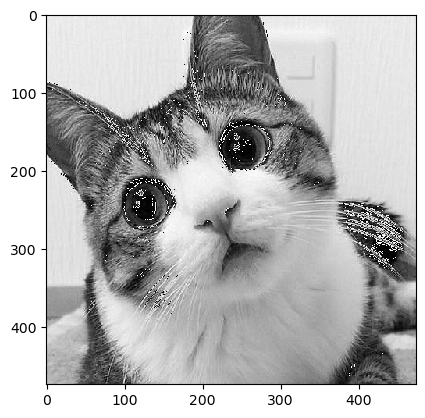

PyObject <matplotlib.image.AxesImage object at 0x7fdf327b6390>

In [381]:
c = cat + UInt8.(uint_filter.(b * 2))
imshow(c)

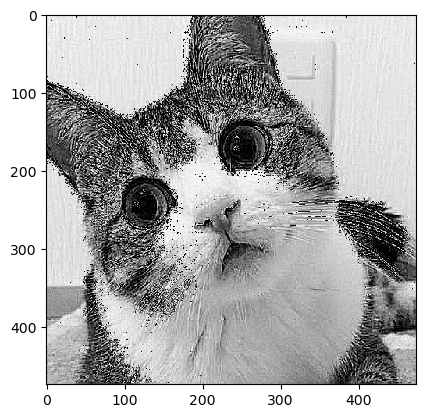

PyObject <matplotlib.image.AxesImage object at 0x7fdf326e4898>

In [383]:
senneika(k, img) = imshow(filtering(img, [-k/9 -k/9 -k/9; -k/9 1+8k/9 -k/9;-k/9 -k/9 -k/9], 3))
senneika(9, cat)

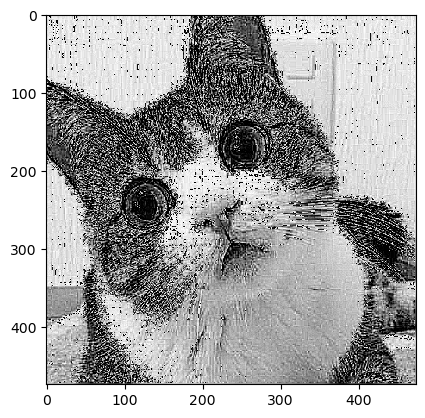

PyObject <matplotlib.image.AxesImage object at 0x7fdf333082e8>

In [328]:
senneika(18, cat)

## 5-5 エッジを保存した平滑化
9このフィルタを画像にかける　-> 9このout = {a1, a2, ...,a9}
filter = [a11 a12 0 0 
          a21 a22 0 0]
tartget = [1 1 0 0
           1 1 0 0]
var_list = []
mean_list = []

for i in 9
  o = img[size(filter)] * target
  out = filtering(o, filter)
  var_list.push(var(out))
  mean_list.push(mean(out))
end
v_min = min(var(out))

### 5-5-1 エッジ保存スムージング
### 5-5-2 k最近隣平均化フィルタ

## バイラテラルフィルタ
$$h(i,j) = \frac{w(i , j, m, n)}{\sum^W_{n = -W} \sum^W_{m = -W} w(i , j, m, n)}$$
をフィルタとしたもの

## 5-6 画像の構成要素の置き換え
画像を格子状に区切り、１つ１つの講師を構成要素とみなすこともできる。（以下これをブロックと呼ぶ）
ブロックを構成要素ごと別のものに置き換えるような処理
- 有名なものでモザイク処理がある。

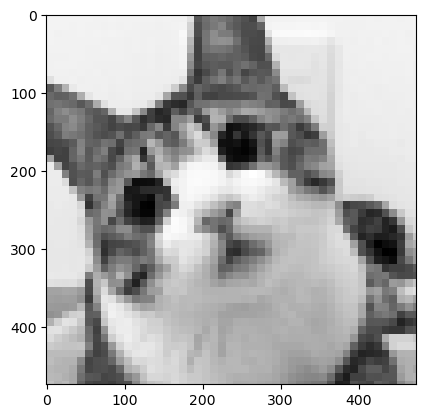

10


PyObject <matplotlib.image.AxesImage object at 0x7fdf3235a470>

In [396]:
block_length = 10
println(block_length)
X, Y = size(cat)
mozaiku = copy(cat)
M, N = X ÷ block_length, Y ÷ block_length
for x ∈ 1:block_length:X
    for y ∈ 1:block_length:Y
        yoko = x+block_length-1
        tate = y+block_length-1
        if yoko > X
            yoko = X
        end
        if tate > Y
            tate = Y
        end
        block = cat[x:yoko, y:tate]
        new_block = ones(UInt8, yoko - x + 1, tate - y + 1) * UInt8(floor(mean(vec(block))))
        mozaiku[x:yoko, y:tate] = new_block
    end
end
imshow(mozaiku)